In [1]:
install.packages("recipes")
install.packages("themis")
library(themis)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.5.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed(

HEART DISEASE DIAGNOSES
=======================

Introduction:
-------------
 
   Heart disease is a range of conditions which affect one's cardiovascular system. The most common condition is coronary artery disease, in which plaque builds up in arteries, narrowing the vessel walls. If the buildup continues, blood will have a hard time flowing through these vessels. This condition can lead to heart attacks or strokes. Several factors influence an individual's likelihood to be diagnosed with this condition, including high blood pressure, high cholesterol, and smoking. Poor diet, excessive drinking, poor fitness, and diabetes are also factors. 
	
   Using the patient statistics in the UC Irvine University dataset, can we accurately predict the heart disease diagnoses of other patients? We will be using the aforementioned data set that lists 14 factors which influence the likelihood of heart disease, as well as the diagnoses of this patient. The diagnosis column ranges from 0-4, with 0 being no heart disease detected, and 4 being an extreme presence of the disease. We will be keeping 75% of the data for training and using 25% of it for testing. We will test the accuracy, precision and recall of the predictions that R makes, based off of this dataset. We will use a K nearest neighbor prediction calculation to test if the UC Irvine University dataset can accurately predict a diagnosis.

Research Question: 
------------------
Can we accurately predict if a patient has heart disease based on their age, resting blood pressure, and cholesterol levels? 



Reading The Data:
-----------------

*Training Data*

In [2]:
## cp = chest pain, trestbps = resting blood pressure, fbs = fasting blood sugar > 120 mg/dl, restecg = resting electrocardiographic results
## thalach = maximum heart rate achieved, exang = exercise induced chest pain, oldpeak = ST depression induced by exercise
## slope = he slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
## ca = number of major vessels(0-3), thal = 3 = normal; 6 = fixed defect; 7 = reversable defect, num = diagnosis of heart disease

col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

url <- "https://raw.githubusercontent.com/JJyang30/Dsci-100-Data/main/processed.cleveland.data"
heart_data <- read.table(url, 
                         col.names = col_names, sep = ",")

heart_data_2 <- heart_data |> 
    filter(ca != "?", thal != "?") |>
    select(age, trestbps, chol, num)|>
    mutate(num = as.factor(num)) 

heart_data_split <- initial_split(heart_data_2, prop = 0.75, strata = num)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)

heart_data_2

age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
68,144,193,2
57,130,131,3
57,130,236,1


## Analysis:

In [3]:
set.seed(2024)

heart_recipe <- recipe(num ~ age + trestbps + chol, data = heart_data_train)|>
    step_upsample(num, over_ratio = 1, skip = FALSE)|>
    prep()

heart_data_train_upsampled <- bake(heart_recipe, heart_data_train)

heart_recipe_final <- recipe(num ~ age + trestbps + chol, data = heart_data_train_upsampled) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
    
heart_vfold <- vfold_cv(heart_data_train, v = 5, strata = num)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3345023,5,0.02926535,Preprocessor1_Model01
2,accuracy,multiclass,0.3345023,5,0.02926535,Preprocessor1_Model02
3,accuracy,multiclass,0.3917226,5,0.01315354,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,multiclass,0.5176946,5,0.01036709,Preprocessor1_Model23
24,accuracy,multiclass,0.5268913,5,0.00554915,Preprocessor1_Model24
25,accuracy,multiclass,0.5268913,5,0.00554915,Preprocessor1_Model25


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
24,accuracy,multiclass,0.5268913,5,0.00554915,Preprocessor1_Model24


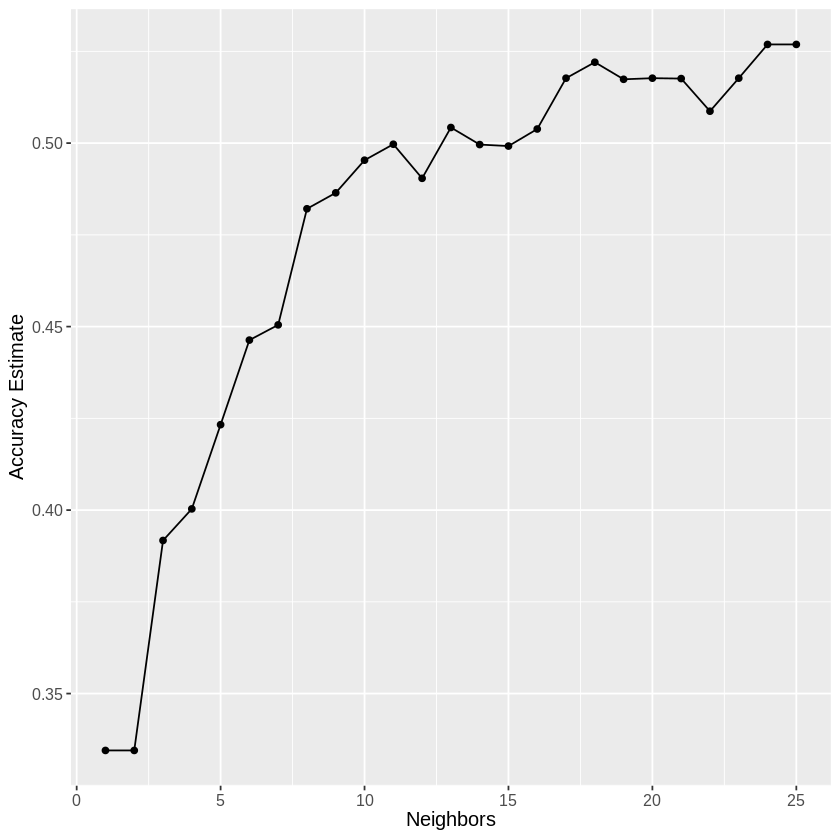

In [4]:

heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

heart_workflow <- workflow() |> 
    add_recipe(heart_recipe_final) |> 
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

knn_accuracies <- heart_workflow |> 
    filter(.metric == "accuracy")

highest_accuracy_k <- knn_accuracies |> 
    arrange(desc(mean)) |>
    head(1)

knn_accuracies_plot <- ggplot(knn_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

knn_accuracies
highest_accuracy_k
knn_accuracies_plot

In [5]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_best_fit <- workflow() |>
       add_recipe(heart_recipe_final) |>
       add_model(knn_best_spec) |>
       fit(data = heart_data_train)

heart_test_predictions <- predict(heart_best_fit, heart_data_test) |>
       bind_cols(heart_data_test)

heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = num, estimate = .pred_class) 

heart_prediction_precision <- heart_test_predictions |>
        precision(truth = num, estimate = .pred_class)

heart_prediction_recall <- heart_test_predictions |>
        recall(truth = num, estimate = .pred_class)

heart_prediction_accuracy
heart_prediction_precision
heart_prediction_recall

Warning message:
“While computing multiclass `precision()`, some levels had no predicted events (i.e. `true_positive + false_positive = 0`). 
Precision is undefined in this case, and those levels will be removed from the averaged result.
Note that the following number of true events actually occured for each problematic event level:
'4': 2”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5733333
kap,multiclass,0.2055611


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.3817797


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.2933083


Methods:
--------
We first read the Heart Disease data frame into R and renamed the columns. We selected the 3 columns that we will use to predict a diagnosis: age, trestbps, and chol, as well as the diagnosis column: num. We split the data set. 75% was retained for training and the remaining 25% were used for testing. Then, we converted the num column (diagnosis) into a factor data type since it is a categorical variable. Next, we created the recipe, heart_data_recipe, which states that age, trestbps, and chol are the predicting factors for a heart disease diagnosis. We scaled and centered these three predictors. Then we made the model, knn_spec, setting the weight function to be rectangular to give each k-nearest neighbor exactly one vote towards the prediction of a new observation. We set the k-value to tune since we would later use cross-validation to select the k-value with the highest accuracy. We used 5-fold cross-validation to assess the accuracy of our predictive model, naming this object hd_vfold. We then picked potential k-values, ranging from one to 25, increasing in increments of 1, and we called this object k_vals. Our justification for using a range of K values between 0 - 25 for cross validation was to restrict the value to be less than 25 to reduce the complexity of our classification as we are using three parameters. This helps decrease the run-time and improve computing efficiency. We also wanted to prevent overfitting since with tests, we have found that K values above 25 does not increase significantly. Therefore, we argue it is better to use a smaller value of K to prevent our system from learning the training data too well and doing poorly on real data. 
 
Subsequently, we combined the pieces of code using a workflow which included our recipe, heart_data_recipe, and model, knn_spec. We used the tune_grid function, setting the resamples argument as hd_vfold, and the grid argument as k_vals. We used the collect_metrics function to compile the average and standard error of the classifier's validation accuracy across the five folds. Next, we filtered the data in order to keep the accuracy row. We then plotted the k-values versus the mean accuracy of our predictive model using that k-value. Additionally, we used the arrange, head, and pull function to find the k-value with the highest accuracy. Both the graph and the numerical value we found showed that a k-value of 12 demonstrated the highest accuracy. 

Lastly, we performed K-nearest neighbor prediction calculations using testing data as the new observations to predict if each patient has heart disease. We compared this prediction to the patient's actual status and calculated the accuracy, precision, and recall of the predictions based on the data from the database.




Discussion:
----------
After running our cross validation we can see that we have a 50% chance of predicting the right diagnosis. This accuracy can be justified since there are a total of 5 classes, 0-4, and random guessing would only give a 20% chance of getting the right class. Therefore, a 50% accuracy through our classification algorithm is understandable despite it not being ideal. A factor that could have affected the accuracy was due to the complexity of the data, since there were 13 possible predictors and we only selected three to predict the class. This level of complexity in the data makes it difficult to make an accurate prediction without over-complicating the algorithm by including all the variables as predictors. If we had done so, potential overfitting may have occurred and the algorithm would have been overloaded with too many dimensions to consider. Hence, contrary to our expectations, we find that this dataset cannot accurately predict the heart disease diagnosis of patients to an extent that will be beneficial to hospitals. A potential implication of this finding is that heart disease is a complex diagnosis and the multitude of factors involved means that it should be considered on a case-by-case basis for accuracy and treatment. The questions that we would like to pose for future consideration is thus whether it is possible for algorithms capable of handling more complex functions to accurately predict heart disease diagnoses and if other predictors will give a more accurate diagnosis for heart diseases.
 





References and Credits:
-----------------------

- Janosi, A., Steinbrunn, W., Pfisterer, M., and Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.


